In [1]:
import os
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import pandas as pd
import matplotlib.pyplot as plt 
torch.backends.cudnn.benchmark=True


In [2]:
labels = pd.read_csv('./duanzipai.txt', sep=r"[ \t]+", names=['r', 'g', 'b', 'name'], header=None,index_col='name')
labels

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6456\3348059759.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv('./duanzipai.txt', sep=r"[ \t]+", names=['r', 'g', 'b', 'name'], header=None,index_col='name')


,r,g,b
name,,,
duanzipaiming,64,0,128
duanzipaihao,192,128,64
haomaguan,0,128,64
beijing,128,128,128


In [3]:
cls2rgb = {cl:list(labels.loc[cl, :]) for cl in labels.index}
cls2rgb

{'duanzipaiming': [64, 0, 128],
 'duanzipaihao': [192, 128, 64],
 'haomaguan': [0, 128, 64],
 'beijing': [128, 128, 128]}

In [4]:
def load_input(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.jpg'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    # equalized_img = cv2.cvtColor(ycrcb_img, cv2.CaOLOR_YCrCb2BGR)
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

    equalized_img = equalized_img[:, :, [2, 1, 0]]
    equalized_img = cv2.resize(equalized_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    input.append(equalized_img)
    
  return np.array(input)


In [5]:
def load_labeled_data(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.png'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    rgb_img = rgb_img[:, :, [2, 1, 0]]
    rgb_img = cv2.resize(rgb_img, dsize=(256, 256))
    input.append(rgb_img)
  return np.array(input)


In [6]:
input = load_input('./nobackground/images')
masks = load_labeled_data('./background/LabeledApproved_full6')

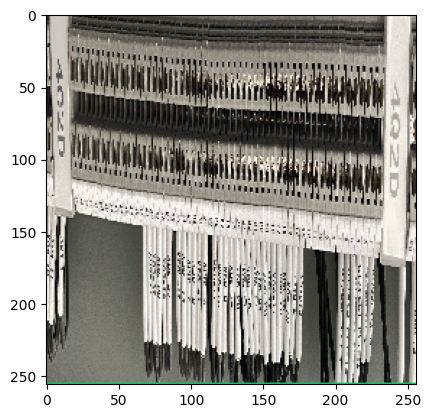

In [7]:
plt.imshow(input[50])

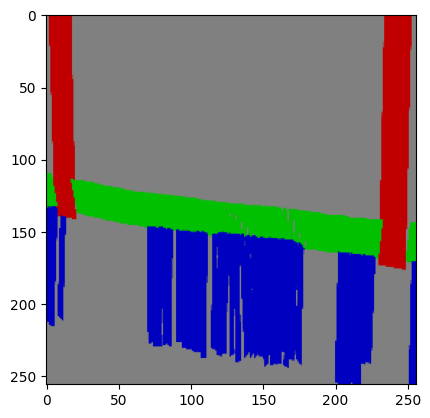

In [8]:
plt.imshow(masks[50])

In [9]:
idx2rgb=[np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())]
idx2rgb

[array([ 64,   0, 128]),
 array([192, 128,  64]),
 array([  0, 128,  64]),
 array([128, 128, 128])]

In [10]:
masks.shape


(1012, 256, 256, 3)

In [11]:
import numpy as np

def adjust_mask(mask, cls2rgb):
    # 将cls2rgb的值转换为numpy数组
    cls_colours = np.array(list(cls2rgb.values()))

    # 初始化语义地图
    semantic_map = np.zeros(mask.shape[:2], dtype=np.int32)

    # 对于mask中的每个像素
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            # 计算当前像素与每个类别颜色的欧氏距离
            distances = np.linalg.norm(cls_colours - mask[i, j], axis=1)
            # 找到最近的类别颜色
            closest_colour_idx = np.argmin(distances)
            # 将该像素归类到最近的类别
            semantic_map[i, j] = closest_colour_idx

    # 将语义地图转换为布尔数组
    semantic_map_bool = np.zeros((mask.shape[0], mask.shape[1], len(cls2rgb)), dtype=np.bool)
    for idx, _ in enumerate(cls2rgb):
        semantic_map_bool[:, :, idx] = (semantic_map == idx)

    return semantic_map_bool

# 示例使用
cls2rgb = {0: [64, 0, 128], 1: [192, 128, 64], 2: [0, 128, 64], 3: [128, 128, 128]}
# adjusted_mask = adjust_mask(masks, cls2rgb)
adjusted_masks = np.array([adjust_mask(mask, cls2rgb) for mask in masks])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6456\4022041548.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  semantic_map_bool = np.zeros((mask.shape[0], mask.shape[1], len(cls2rgb)), dtype=np.bool)


In [12]:
adjusted_masks 

array([[[[False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True]],

        [[False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True]],

        [[False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True]],

        ...,

        [[False, False, False,  True],
         [False, False, False,  True],
         [False, False, False,  True],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False, False, Fal

In [13]:
masks= adjusted_masks.astype(int)

In [14]:
import numpy as np

# 假设 rgb_mask[50] 是你的数组
unique_values = np.unique(masks[0])
print("Unique values:", unique_values)
print("Number of unique values:", len(unique_values))


Unique values: [0 1]
Number of unique values: 2


In [15]:
import numpy as np

# 假设 masks[50] 是你的数组
mask = masks[0]
height, width, depth = mask.shape

# 初始化一个布尔数组，用于存储每个向量是否恰好包含一个 1
contains_single_one = np.zeros((height, width), dtype=bool)

# 遍历数组的每个向量
for i in range(height):
    for j in range(width):
        # 计算每个向量中 1 的个数
        count_ones = np.sum(mask[i, j, :] == 1)
        # 判断是否恰好有一个 1，并更新布尔数组
        contains_single_one[i, j] = (count_ones == 1)

# 检查结果
print("Does each vector contain exactly one '1'?:")
print(contains_single_one)


Does each vector contain exactly one '1'?:
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [16]:
import numpy as np

def verify_mask(mask):
    # 检查每个像素点是否至少有一个类别被标记为1
    return np.all(np.sum(mask, axis=-1) >= 1)

# 假设 masks 是您已经处理过的掩码数组
verification_result = verify_mask(masks[0])

print("每个像素至少属于一个类别:", verification_result)


每个像素至少属于一个类别: True


In [17]:
masks[0][0][0]

array([0, 0, 0, 1])

In [18]:
def conv_mask(masks):
  out = []
  for mask in masks:
    out.append(np.argmax(mask, axis=-1))
  return np.array(out)

In [19]:
rgb_mask = conv_mask(masks)

In [20]:
rgb_mask[0][0][0]

3

In [21]:
# del one_hot_masks

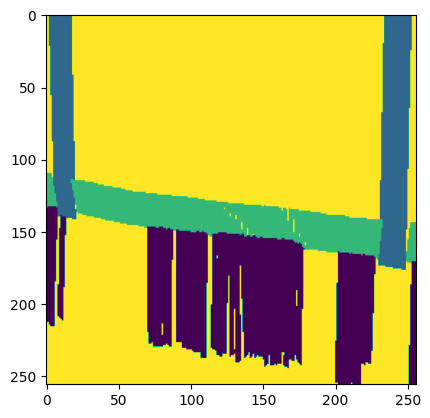

In [22]:
plt.imshow(rgb_mask[50])

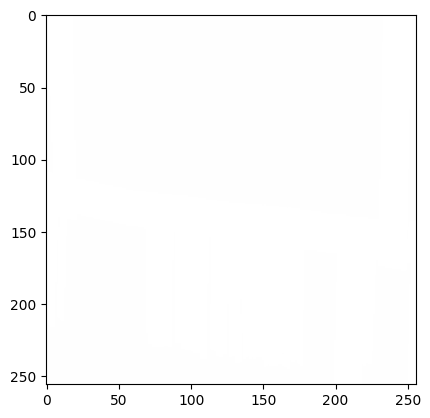

In [23]:
plt.imshow(masks[50])

In [24]:
train_data = []
for i in range(len(input)):
   train_data.append([input[i], rgb_mask[i], masks[i]])
# train,valid,test = torch.utils.data.random_split(train_data, [700,200,112])
train,valid,test = torch.utils.data.random_split(train_data, [896,112,4])



In [25]:
num_clients = 7
num_selected = 7
num_edge_servers=3
num_rounds = 20
epochs = 6
batch_size = 4

In [26]:
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)

In [27]:
# from fightingcv_attention.attention.CBAM import CBAMBlock

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=True)
        else:
            x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x



class SegNetBaseBatchNorm(nn.Module):
    def __init__(self, input_channel):
        super(SegNetBaseBatchNorm, self).__init__()
        self.inc = inconv(input_channel, 64)
#         self.cbam = CBAMBlock(channel=64,reduction=8,kernel_size=7)
        self.down1 = down(64, 128)
#         self.cbam1 = CBAMBlock(channel=128,reduction=8,kernel_size=7)
        self.down2 = down(128, 256)
#         self.cbam2 = CBAMBlock(channel=256,reduction=8,kernel_size=7)
        self.down3 = down(256, 512)
#         self.cbam3 = CBAMBlock(channel=512,reduction=8,kernel_size=7)
        self.down4 = down(512, 512)
#         self.cbam4 = CBAMBlock(channel=512,reduction=8,kernel_size=7)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, 4)

    def forward(self, x):
        # print('x shape :',x.shape)#torch.Size([4, 3, 256, 256])
        x1 = self.inc(x)
#         x1 = self.cbam(x1)
        # print('x1 shape :',x1.shape)#torch.Size([4, 64, 256, 256])
        x2 = self.down1(x1)
#         x2 = self.cbam1(x2)
        # print('x2 shape :',x2.shape)#torch.Size([4, 128, 128, 128])
        x3 = self.down2(x2)
#         x3 = self.cbam2(x3)
        # print('x3 shape :',x3.shape)#torch.Size([4, 256, 64, 64])
        x4 = self.down3(x3)
#         x4 = self.cbam3(x4)
        # print('x4 shape :',x4.shape)#torch.Size([4, 512, 32, 32])
        x5 = self.down4(x4)
#         x5 = self.cbam4(x5)
        # print('x5 shape :',x5.shape)#torch.Size([4, 512, 16, 16])
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #return F.sigmoid(x)

        return x,x2,x4
# x shape : torch.Size([4, 3, 256, 256])
# x1 shape : torch.Size([4, 64, 256, 256])
# x2 shape : torch.Size([4, 128, 128, 128])
# x3 shape : torch.Size([4, 256, 64, 64])
# x4 shape : torch.Size([4, 512, 32, 32])
# x5 shape : torch.Size([4, 512, 16, 16])

In [28]:
# def server_aggregate(global_model, client_models):
#     """
#     This function has aggregation method 'mean'
#     """
#     ### This will take simple mean of the weights of models ###
#     global_dict = global_model.state_dict()
#     for k in global_dict.keys():
#       global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
#     global_model.load_state_dict(global_dict)
#     for model in client_models:
#       model.load_state_dict(global_model.state_dict())

In [29]:
def edge_aggregate(edge_model, client_models):
    edge_dict = edge_model.state_dict()
    for k in edge_dict.keys():
        edge_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    edge_model.load_state_dict(edge_dict)
    for model in client_models:
        model.load_state_dict(edge_model.state_dict())

In [30]:
# def cloud_aggregate(cloud_model, edge_models):
#     cloud_dict = cloud_model.state_dict()
#     for k in cloud_dict.keys():
#         cloud_dict[k] = torch.stack([edge_models[i].state_dict()[k].float() for i in range(len(edge_models))], 0).mean(0)
#     cloud_model.load_state_dict(cloud_dict)
#     for model in edge_models:
#       model.load_state_dict(cloud_model.state_dict())

In [31]:
def cloud_aggregate(cloud_model, edge_models):
    cloud_dict = cloud_model.state_dict()
    # 定义每个边缘服务器模型的权重
    weights = [0.5, 0.3, 0.2]

    for k in cloud_dict.keys():
        # 计算加权平均
        weighted_avg = sum(edge_models[i].state_dict()[k].float() * weights[i] for i in range(len(edge_models)))
        cloud_dict[k] = weighted_avg

    cloud_model.load_state_dict(cloud_dict)
    # 更新边缘服务器层模型
    for model in edge_models:
        model.load_state_dict(cloud_model.state_dict())


In [32]:
import torchvision.transforms as transforms

# 定义数据增强转换
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # 可以根据需要添加更多转换
])


from torchvision.transforms import functional as TF

def apply_transforms_to_batch(batch):
    transformed_batch = []
    for images, labels, _ in batch:
        # 确保图像是正确的格式 (批次大小, 高度, 宽度, 通道数)
        if len(images.shape) == 4 and images.shape[-1] == 3:
            # 转换为(批次大小, 通道数, 高度, 宽度)
            images = images.permute(0, 3, 1, 2)
            transformed_images = []
            for img in images:
                # 应用数据增强，例如随机水平翻转
                if torch.rand(1).item() > 0.5:
                    img = TF.hflip(img)
                # 可以添加更多的数据增强操作
                transformed_images.append(img)
            transformed_batch.append((torch.stack(transformed_images), labels, _))
        else:
            raise ValueError("Unexpected image shape: {}".format(images.shape))
    return transformed_batch


In [33]:
def select_and_upload_data(client_data_loader, percentage=0.5):
    # 选择一部分数据
    selected_data = []
    total_batches = len(client_data_loader)
    selected_batches = int(total_batches * percentage)

    for i, data in enumerate(client_data_loader):
        if i >= selected_batches:
            break
        selected_data.append(data)

    # 返回选定的数据，模拟上传
    return selected_data


In [34]:
def train_on_received_data(edge_model, received_data, optimizer, epochs):
    """
    This function trains the edge model on the data received from clients.
    """
    total_samples = 0
    edge_model.train()
    for epoch in range(epochs):
        for client_data in received_data:
#             print('length of client_data:',len(client_data))
#             transformed_client_data = apply_transforms_to_batch(client_data)
            transformed_client_data = client_data

            for batch_idx, (data, target, _) in enumerate(transformed_client_data):
                inputs, labels = data.to(device), target.to(device)
                total_samples += inputs.size(0) 
                optimizer.zero_grad()
                outputs, feat_S, feat_T = edge_model(inputs.permute((0,3,1,2)).float())
#                 outputs = edge_model(inputs.float())
                outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
                outputs = torch.transpose(outputs,1,2).contiguous()
                outputs = outputs.view(-1,outputs.size(2))

                loss = criterion(outputs, labels.reshape(-1))
                loss.backward()
                optimizer.step()
#     print('Total samples processed by edge server:', total_samples)
    return loss.item()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6456\4238217300.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  semantic_map_bool = np.zeros((mask.shape[0], mask.shape[1], len(cls2rgb)), dtype=np.bool)


Unique values: [0 1]
Number of unique values: 2
Does each vector contain exactly one '1'?:
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
每个像素至少属于一个类别: True


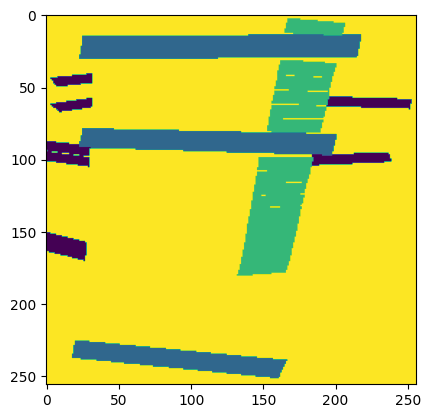

In [35]:
input = load_input('./combined')
masks = load_labeled_data('./new_masks')
plt.imshow(input[50])
plt.imshow(masks[50])
idx2rgb=[np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())]
idx2rgb
masks.shape
import numpy as np

def adjust_mask(mask, cls2rgb):
    # 将cls2rgb的值转换为numpy数组
    cls_colours = np.array(list(cls2rgb.values()))

    # 初始化语义地图
    semantic_map = np.zeros(mask.shape[:2], dtype=np.int32)

    # 对于mask中的每个像素
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            # 计算当前像素与每个类别颜色的欧氏距离
            distances = np.linalg.norm(cls_colours - mask[i, j], axis=1)
            # 找到最近的类别颜色
            closest_colour_idx = np.argmin(distances)
            # 将该像素归类到最近的类别
            semantic_map[i, j] = closest_colour_idx

    # 将语义地图转换为布尔数组
    semantic_map_bool = np.zeros((mask.shape[0], mask.shape[1], len(cls2rgb)), dtype=np.bool)
    for idx, _ in enumerate(cls2rgb):
        semantic_map_bool[:, :, idx] = (semantic_map == idx)

    return semantic_map_bool

# 示例使用
cls2rgb = {0: [64, 0, 128], 1: [192, 128, 64], 2: [0, 128, 64], 3: [128, 128, 128]}
# adjusted_mask = adjust_mask(masks, cls2rgb)
adjusted_masks = np.array([adjust_mask(mask, cls2rgb) for mask in masks])
adjusted_masks 
masks= adjusted_masks.astype(int)
import numpy as np

# 假设 rgb_mask[50] 是你的数组
unique_values = np.unique(masks[0])
print("Unique values:", unique_values)
print("Number of unique values:", len(unique_values))

import numpy as np

# 假设 masks[50] 是你的数组
mask = masks[0]
height, width, depth = mask.shape

# 初始化一个布尔数组，用于存储每个向量是否恰好包含一个 1
contains_single_one = np.zeros((height, width), dtype=bool)

# 遍历数组的每个向量
for i in range(height):
    for j in range(width):
        # 计算每个向量中 1 的个数
        count_ones = np.sum(mask[i, j, :] == 1)
        # 判断是否恰好有一个 1，并更新布尔数组
        contains_single_one[i, j] = (count_ones == 1)

# 检查结果
print("Does each vector contain exactly one '1'?:")
print(contains_single_one)


import numpy as np

def verify_mask(mask):
    # 检查每个像素点是否至少有一个类别被标记为1
    return np.all(np.sum(mask, axis=-1) >= 1)

# 假设 masks 是您已经处理过的掩码数组
verification_result = verify_mask(masks[0])

print("每个像素至少属于一个类别:", verification_result)
masks[0][0][0]

def conv_mask(masks):
  out = []
  for mask in masks:
    out.append(np.argmax(mask, axis=-1))
  return np.array(out)

rgb_mask = conv_mask(masks)
rgb_mask[0][0][0]
plt.imshow(rgb_mask[50])
plt.imshow(masks[50])



In [36]:
train_data = []
for i in range(len(input)):
   train_data.append([input[i], rgb_mask[i], masks[i]])

In [37]:
batch_sizee = 4
edgeloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_sizee)

In [38]:
dataset = edgeloader.dataset
total_size = len(dataset)
total_size

10332

In [39]:
def train_on_received_data(edge_model, edgeloader, optimizer, epochs):
    """
    This function trains the edge model on the data from edgeloader.
    """
    total_samples = 0
    edge_model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target,_) in enumerate(edgeloader):
            inputs, labels = data.to(device), target.to(device)
            total_samples += inputs.size(0)
            optimizer.zero_grad()
            outputs, feat_S, feat_T = edge_model(inputs.permute((0,3,1,2)).float())
            outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
            outputs = torch.transpose(outputs,1,2).contiguous()
            outputs = outputs.view(-1,outputs.size(2))

            loss = criterion(outputs, labels.reshape(-1))
            loss.backward()
            optimizer.step()
    return loss.item()


In [40]:
from torch.utils.data import Subset, DataLoader

def split_dataloader(edgeloader, splits):
    """
    将总的 DataLoader 拆分成多个部分。
    edgeloader: 包含所有数据的 DataLoader。
    splits: 一个整数列表，表示每个部分应该有多少个批次。
    """
    # 获取原始的 Dataset
    dataset = edgeloader.dataset
    total_size = len(dataset)
    indices = torch.randperm(total_size).tolist()

    # 根据 splits 拆分 indices
    split_indices = []
    current = 0
    for split in splits:
        start = int(total_size * current / sum(splits))
        end = int(total_size * (current + split) / sum(splits))
        split_indices.append(indices[start:end])
        current += split

    # 为每个子集创建 DataLoader
    split_loaders = [DataLoader(Subset(dataset, indices), batch_size=edgeloader.batch_size, shuffle=True) for indices in split_indices]

    return split_loaders


In [41]:
# def select_and_pass_data(edge_data, percentage=0.5):
#     # 选择一部分数据
#     selected_data = []
#     total_batches = sum(len(data_loader) for data_loader in edge_data)
#     selected_batches = int(total_batches * percentage)

#     current_batch = 0
#     for data_loader in edge_data:
#         for data in data_loader:
#             if current_batch >= selected_batches:
#                 return selected_data
#             selected_data.append(data)
#             current_batch += 1

#     return selected_data

In [42]:
from torch.utils.data import DataLoader, Subset

def select_and_pass_data(edgeloader, percentage=0.5):
    """
    从给定的 DataLoader 中选择一部分数据。
    edgeloader: 原始的 DataLoader。
    percentage: 要选择的数据比例。
    """
    # 获取原始的 Dataset
    dataset = edgeloader.dataset
    total_size = len(dataset)
    subset_size = int(total_size * percentage)

    # 生成随机索引
    indices = torch.randperm(total_size)[:subset_size].tolist()

    # 创建一个新的 DataLoader，它只包含选定的数据
    subset = Subset(dataset, indices)
    subset_loader = DataLoader(subset, batch_size=edgeloader.batch_size, shuffle=True)

    return subset_loader


In [43]:
def cloud_server_process(cloud_model, edge_data, edge_models, optimizer, epochs):
    # 首先进行模型聚合
    cloud_aggregate(cloud_model, edge_models)
    total_samples = 0

    # 然后使用边缘服务器的数据训练全局云模型
    cloud_model.train()
    for epoch in range(epochs):
        for edge_data_loader in edge_data:
#             transformed_edge_data = apply_transforms_to_batch(edge_data_loader)
            transformed_edge_data = edge_data_loader

#             print('length of edge_data_loader: ',len(edge_data_loader))
            for batch_idx, (data, target, _) in enumerate(transformed_edge_data):
                inputs, labels = data.to(device), target.to(device)
                total_samples += inputs.size(0)
                optimizer.zero_grad()
                outputs, feat_S, feat_T = cloud_model(inputs.permute((0,3,1,2)).float())
#                 outputs = cloud_model(inputs.float())
                outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
                outputs = torch.transpose(outputs,1,2).contiguous()
                outputs = outputs.view(-1,outputs.size(2))

                loss = criterion(outputs, labels.reshape(-1))
                loss.backward()
                optimizer.step()
#     print('Total samples processed by cloud server:', total_samples)


In [44]:
class BackCELoss(nn.Module):
    def __init__(self, ignore_lb=255):
        super(BackCELoss, self).__init__()
        self.ignore_lb = ignore_lb
        self.class_num = 4
        self.criteria = nn.NLLLoss(ignore_index=ignore_lb, reduction='mean')
    def forward(self, logits, labels):
        total_labels = torch.unique(labels)
        new_labels = labels.clone()
        probs = torch.softmax(logits,1)
        fore_ = []
        back_ = []
        
        for l in range(self.class_num):
            if l in total_labels:
                fore_.append(probs[:,l,:,:].unsqueeze(1))
            else: 
                back_.append(probs[:,l,:,:].unsqueeze(1))
        Flag=False
        if not  len(fore_)==self.class_num:
            fore_.append(sum(back_))
            Flag=True
        
        for i,l in enumerate(total_labels):
            if Flag :
                new_labels[labels==l]=i
            else: 
                if l!=255:
                    new_labels[labels==l]=i
            
        probs  =torch.cat(fore_,1)
        logprobs = torch.log(probs+1e-7)
        return self.criteria(logprobs,new_labels.long())

In [45]:
class CriterionPixelPair(nn.Module):
    def __init__(self,temperature=0.1,ignore_index=255, ):
        super(CriterionPixelPair, self).__init__()
        self.ignore_index = ignore_index
        self.temperature = temperature
#         self.args= args

    def pair_wise_sim_map(self, fea_0, fea_1):
        C, H, W = fea_0.size()

        fea_0 = fea_0.reshape(C, -1).transpose(0, 1)
        fea_1 = fea_1.reshape(C, -1).transpose(0, 1)
        # 在 pair_wise_sim_map 中
#         print("fea_0 reshaped size:", fea_0.size())
#         print("fea_1 reshaped size:", fea_1.size())
        
        sim_map_0_1 = torch.mm(fea_0, fea_1.transpose(0, 1))
        return sim_map_0_1

    def forward(self, feat_S, feat_T):
        #feat_T = self.concat_all_gather(feat_T)
        #feat_S = torch.cat(GatherLayer.apply(feat_S), dim=0)
        B, C, H, W = feat_S.size()

        device = feat_S.device
        patch_w = 2
        patch_h = 2
        #maxpool = nn.MaxPool2d(kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w), padding=0, ceil_mode=True)
        maxpool = nn.AvgPool2d(kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w), padding=0, ceil_mode=True)
        feat_S = maxpool(feat_S)
        feat_T= maxpool(feat_T)
        feat_S = F.normalize(feat_S, p=2, dim=1)
        feat_T = F.normalize(feat_T, p=2, dim=1)
        
        sim_dis = torch.tensor(0.).to(device)
        for i in range(B):
            s_sim_map = self.pair_wise_sim_map(feat_S[i], feat_S[i])
            t_sim_map = self.pair_wise_sim_map(feat_T[i], feat_T[i])

            p_s = F.log_softmax(s_sim_map / self.temperature, dim=1)
            p_t = F.softmax(t_sim_map / self.temperature, dim=1)

            sim_dis_ = F.kl_div(p_s, p_t, reduction='batchmean')
            sim_dis += sim_dis_
        sim_dis = sim_dis / B 
        return sim_dis

In [46]:
def apply_fourier_transform(loss, alpha):
    # 确保损失是一维张量
    if loss.ndim > 1:
        loss = loss.mean()

    # 检查损失是否为空
    if loss.numel() == 0:
        raise ValueError("Loss tensor is empty. Fourier transform cannot be applied.")

    # 傅里叶变换
    loss_fft = torch.fft.fft(loss)
    
    # 在频域中乘以系数 alpha
    loss_fft_alpha = alpha * loss_fft
    
    # 反傅里叶变换
    loss_modified = torch.fft.ifft(loss_fft_alpha)
    
    # 取实部作为最终损失
    return loss_modified.real

In [47]:
def client_update(model, optimizer, train_loader, criterion_backce, criterion_pixel_pair, alpha, epoch=5):
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target, _) in enumerate(train_loader):
            inputs, labels = data.to(device), target.to(device)
            optimizer.zero_grad()

            outputs, feat_S, feat_T = model(inputs.permute((0,3,1,2)).float())

            loss_backce = criterion_backce(outputs, labels)

            # 调整特征图尺寸以匹配
            feat_S = F.adaptive_avg_pool2d(feat_S, (16, 16))  # 使用自适应平均池化
            feat_T = F.adaptive_avg_pool2d(feat_T, (16, 16))

#             print("feat_S size after pooling:", feat_S.size())
#             print("feat_T size after pooling:", feat_T.size())

            loss_pixel_pair = criterion_pixel_pair(feat_S, feat_T)
#             # 应用傅里叶变换和反变换
#             loss_pixel_pair_modified = apply_fourier_transform(loss_pixel_pair, alpha)
            # 确保损失张量非空且为一维
            if loss_pixel_pair.numel() > 0 and loss_pixel_pair.ndim == 1:
            # 应用傅里叶变换和反变换
                loss_pixel_pair_modified = apply_fourier_transform(loss_pixel_pair, alpha)
            else:
                loss_pixel_pair_modified = alpha * loss_pixel_pair
    

#             loss = loss_backce + alpha * loss_pixel_pair
            # 总损失
            loss = loss_backce + loss_pixel_pair_modified
            loss.backward()
            optimizer.step() 
    return loss.item()


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
                                                                                                                                                

def validation(model, validation_loader, criterion_backce):
    model.eval()
    running_valid_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target, _ in validation_loader:
            inputs, labels = data.to(device), target.to(device)

            outputs, _, _ = model(inputs.permute((0,3,1,2)).float())  # 只使用 outputs
            loss = criterion_backce(outputs, labels)  # 使用 outputs 计算损失
            running_valid_loss += loss.item()

            outputs_np = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
            labels_np = labels.cpu().numpy().flatten()

            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    miou = jaccard_score(all_labels, all_preds, average='macro')

    val_loss = running_valid_loss / len(validation_loader.dataset)

    return val_loss, accuracy, precision, recall, f1, miou


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [50]:
# import torch.optim as optim
# global_model = SegNetBaseBatchNorm(3).to(device)
# edge_models = [SegNetBaseBatchNorm(3).to(device) for _ in range(num_edge_servers)]

# torch.manual_seed(0)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [51]:
import torch.optim as optim
global_model = SegNetBaseBatchNorm(3).to(device)
edge_models = [SegNetBaseBatchNorm(3).to(device) for _ in range(num_edge_servers)]

torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
# 初始化损失函数
criterion_backce = BackCELoss()  # args 需要包含所需的参数
criterion_pixel_pair = CriterionPixelPair()  # args 需要包含所需的参数
alpha=0.5
optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)
cloud_optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [52]:

############## client models ##############
client_models = [ SegNetBaseBatchNorm(3).to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005) for model in client_models]
edge_optimizers = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005) for model in edge_models]

In [53]:
# 示例：客户端位置（这里使用简单的坐标，您可以根据实际情况调整）
client_locations = [(39.995304, 116.308264), (40.003304, 116.326759), (41.123394, 117.225750),
                    (69.003304, 116.326759),(70.003304, 116.326759),(71.003304, 117.326759),
                   (80.003304, 80.326759)]
# 示例：边缘雾模型位置
edge_server_locations = [(40.103302, 116.526779), (70.103302, 116.526779), (80.003304, 82.326759)]


In [54]:
import geopy.distance

def assign_clients_to_edge_servers(client_locations, edge_server_locations):
    assignments = [[] for _ in edge_server_locations]
    for client_idx, client_location in enumerate(client_locations):
        distances = [geopy.distance.distance(client_location, edge_location).km for edge_location in edge_server_locations]
        nearest_edge_idx = distances.index(min(distances))
        assignments[nearest_edge_idx].append(client_idx)
    return assignments

# 分配客户端到最近的边缘雾模型
client_assignments = assign_clients_to_edge_servers(client_locations, edge_server_locations)


In [55]:
client_assignments

[[0, 1, 2], [3, 4, 5], [6]]

In [56]:
# for r in range(num_rounds):
#     # 随机选择客户端
# # #     client_idx = np.random.permutation(num_clients)[:num_selecte]

#     # 更新本地模型
#     loss = 0
#     for i in range(num_selected):
# #         idx = client_id[i]
#         loss += client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
#         torch.save(client_models[i].state_dict(), f'./local_model1{i}.pth')
#     losses_train.append(loss)

#     # 聚合到边缘雾模型
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         selected_client_models = [client_models[i] for i in selected_client_indices]
#         edge_aggregate(edge_model, selected_client_models)

#     # 聚合到全局云模型
#     cloud_aggregate(global_model, edge_models)
#     torch.save(global_model.state_dict(), './global_model1.pth')

#     # 验证全局模型
#     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader)
#     losses_val.append(val_loss)
#     print(f'{r}-th round: average train loss {loss / num_selected:.3g} | test loss {val_loss:.3g}')
#     print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')


In [57]:
client_idx = np.random.permutation(num_clients)[:num_selected]
client_idx

array([0, 1, 5, 4, 6, 3, 2])

In [58]:
edgeloader

In [59]:
dataset = edgeloader.dataset
total_size = len(dataset)
total_size

10332

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL
epochs=10
epochss=10
num_rounds=10
# 假设您有 3 个边缘服务器，您想要按照一定的比例拆分数据
splits = [1, 1, 1]  # 假设平均拆分

# 拆分 DataLoader
split_loaders = split_dataloader(edgeloader, splits)
for r in range(num_rounds):
    # 更新本地模型并上传数据
    uploaded_data = []
    client_idx = np.random.permutation(num_clients)[:num_selected]
    for i in range(num_selected):
        loss = client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epochs)
        losses_train.append(loss)
        # 选择并上传数据
        client_data = select_and_upload_data(train_loader[i])
        uploaded_data.append(client_data)

    # 聚合到边缘雾模型
    # print("Length of uploaded_data:", len(uploaded_data))
    edge_data_for_cloud = []
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         # print(f"Selected client indices for edge server {edge_idx}:", selected_client_indices)
#         selected_client_models = [client_models[i] for i in selected_client_indices]
#         selected_client_data = [uploaded_data[i] for i in selected_client_indices]
#         # print(f"Edge Server {edge_idx}, selected_client_data: {selected_client_data}")
#         # print(f"Edge Server {edge_idx}, selected_client_indices: {selected_client_indices}")
#         # selected_edge_data = [selected_client_data[i] for i in selected_client_indices]
#         edge_aggregate(edge_model, selected_client_models)
#         # 在这里可以使用 selected_client_data 进行额外的处理
#         edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochs)

#     # 边缘服务器上传数据给云服务器（模拟）
    

#         selected_data = select_and_pass_data(selected_client_data)
#         edge_data_for_cloud.append(selected_data)
    for edge_idx, edge_model in enumerate(edge_models):
        selected_client_indices = client_assignments[edge_idx]
        selected_client_models = [client_models[i] for i in selected_client_indices]
        edge_aggregate(edge_model, selected_client_models)
    
    # 假设您已经有了为每个边缘服务器准备的 edgeloader
#         edgeloader = prepare_edgeloader_for_edge_server(selected_client_data)
        edgeloader = split_loaders[edge_idx]
    
    # 使用 edgeloader 进行训练
        edge_loss = train_on_received_data(edge_model, edgeloader, edge_optimizers[edge_idx], epochs)

        selected_data = select_and_pass_data(edgeloader)
        edge_data_for_cloud.append(selected_data)
    # 聚合到全局云模型并处理数据

    cloud_server_process(global_model, edge_data_for_cloud, edge_models, cloud_optimizer, epochs)
    for edge_idx, edge_model in enumerate(edge_models):
        edge_model_dict = edge_model.state_dict()
        selected_client_indices = client_assignments[edge_idx]
        for client_idx in selected_client_indices:
            client_models[client_idx].load_state_dict(edge_model_dict)

    # 验证全局模型
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)
    losses_val.append(val_loss)
    print(f'{r}-th round: average train loss {loss / num_selected:.3g} | test loss {val_loss:.3g}')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')








0-th round: average train loss 0.0357 | test loss 0.243
Accuracy: 0.6741089139665876, Precision: 0.6056927533985486, Recall: 0.6076298715635456, F1: 0.5707827033404551, mIoU: 0.41277983412935726
1-th round: average train loss 0.0233 | test loss 0.199
Accuracy: 0.717768805367606, Precision: 0.610861334851874, Recall: 0.7070449771720838, F1: 0.631889481651272, mIoU: 0.47314841544074526
2-th round: average train loss 0.0138 | test loss 0.223
Accuracy: 0.6998897280011859, Precision: 0.6001748602245165, Recall: 0.6789911465286345, F1: 0.6110439762394927, mIoU: 0.45118076492872816
3-th round: average train loss 0.0188 | test loss 0.229
Accuracy: 0.7121214185442243, Precision: 0.6237160002013213, Recall: 0.6951237501393995, F1: 0.6312908736235061, mIoU: 0.4719947905176786


In [ ]:
stop

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL
epochs=2
epochss=2
num_rounds=5
# 假设您有 3 个边缘服务器，您想要按照一定的比例拆分数据
splits = [1, 1, 1]  # 假设平均拆分

# 拆分 DataLoader
split_loaders = split_dataloader(edgeloader, splits)
for r in range(num_rounds):
    # 更新本地模型并上传数据
    uploaded_data = []
    client_idx = np.random.permutation(num_clients)[:num_selected]
    for i in range(num_selected):
        loss = client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epochs)
        losses_train.append(loss)
        # 选择并上传数据
        client_data = select_and_upload_data(train_loader[i])
        uploaded_data.append(client_data)

    # 聚合到边缘雾模型
    # print("Length of uploaded_data:", len(uploaded_data))
    edge_data_for_cloud = []
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         # print(f"Selected client indices for edge server {edge_idx}:", selected_client_indices)
#         selected_client_models = [client_models[i] for i in selected_client_indices]
#         selected_client_data = [uploaded_data[i] for i in selected_client_indices]
#         # print(f"Edge Server {edge_idx}, selected_client_data: {selected_client_data}")
#         # print(f"Edge Server {edge_idx}, selected_client_indices: {selected_client_indices}")
#         # selected_edge_data = [selected_client_data[i] for i in selected_client_indices]
#         edge_aggregate(edge_model, selected_client_models)
#         # 在这里可以使用 selected_client_data 进行额外的处理
#         edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochs)

#     # 边缘服务器上传数据给云服务器（模拟）
    

#         selected_data = select_and_pass_data(selected_client_data)
#         edge_data_for_cloud.append(selected_data)
    for edge_idx, edge_model in enumerate(edge_models):
        selected_client_indices = client_assignments[edge_idx]
        selected_client_models = [client_models[i] for i in selected_client_indices]
        edge_aggregate(edge_model, selected_client_models)
    
    # 假设您已经有了为每个边缘服务器准备的 edgeloader
#         edgeloader = prepare_edgeloader_for_edge_server(selected_client_data)
        edgeloader = split_loaders[edge_idx]
    
    # 使用 edgeloader 进行训练
        edge_loss = train_on_received_data(edge_model, edgeloader, edge_optimizers[edge_idx], epochs)

        selected_data = select_and_pass_data(edgeloader)
        edge_data_for_cloud.append(selected_data)
    # 聚合到全局云模型并处理数据

    cloud_server_process(global_model, edge_data_for_cloud, edge_models, cloud_optimizer, epochs)
    for edge_idx, edge_model in enumerate(edge_models):
        edge_model_dict = edge_model.state_dict()
        selected_client_indices = client_assignments[edge_idx]
        for client_idx in selected_client_indices:
            client_models[client_idx].load_state_dict(edge_model_dict)

    # 验证全局模型
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)
    losses_val.append(val_loss)
    print(f'{r}-th round: average train loss {loss / num_selected:.3g} | test loss {val_loss:.3g}')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')








In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL
epochs=100
epochss=100
num_rounds=50
for r in range(num_rounds):
    # 更新本地模型并上传数据
    uploaded_data = []
    client_idx = np.random.permutation(num_clients)[:num_selected]
    for i in range(num_selected):
        loss = client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epochs)
#         torch.save(client_models[i].state_dict(), f'./local_model1{i}.pth')
#         torch.save(client_models[i].state_dict(), f'./local_model1{i}.pth')
        losses_train.append(loss)
        # 选择并上传数据
        client_data = select_and_upload_data(train_loader[i])
        uploaded_data.append(client_data)

    # 聚合到边缘雾模型
    # print("Length of uploaded_data:", len(uploaded_data))
    edge_data_for_cloud = []
    for edge_idx, edge_model in enumerate(edge_models):
        selected_client_indices = client_assignments[edge_idx]
        # print(f"Selected client indices for edge server {edge_idx}:", selected_client_indices)
        selected_client_models = [client_models[i] for i in selected_client_indices]
        selected_client_data = [uploaded_data[i] for i in selected_client_indices]
        # print(f"Edge Server {edge_idx}, selected_client_data: {selected_client_data}")
        # print(f"Edge Server {edge_idx}, selected_client_indices: {selected_client_indices}")
        # selected_edge_data = [selected_client_data[i] for i in selected_client_indices]
        edge_aggregate(edge_model, selected_client_models)
        # 在这里可以使用 selected_client_data 进行额外的处理
        edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochs)

    # 边缘服务器上传数据给云服务器（模拟）
    
    # for edge_idx, edge_model in enumerate(edge_models):
    #     selected_client_indices = client_assignments[edge_idx]
    #     selected_edge_data = [selected_client_data[i] for i in selected_client_indices]
        selected_data = select_and_pass_data(selected_client_data)
        edge_data_for_cloud.append(selected_data)

    # 聚合到全局云模型并处理数据
#     cloud_aggregate(global_model, edge_models)
#     cloud_server_process(global_model, edge_data_for_cloud, cloud_optimizer, epochs)
#     edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochs)
    cloud_server_process(global_model, edge_data_for_cloud, edge_models, cloud_optimizer, epochs)


    # 验证全局模型
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)
    losses_val.append(val_loss)
    print(f'{r}-th round: average train loss {loss / num_selected:.3g} | test loss {val_loss:.3g}')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')





# for r in range(num_rounds):
#     # 更新本地模型并上传数据
#     selected_client_data = []
#     client_idx = np.random.permutation(num_clients)[:num_selected]
#     for i in range(num_selected):
#         loss = client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epochs)
# #         torch.save(client_models[i].state_dict(), f'./local_model1{i}.pth')
#         losses_train.append(loss)
#         # 选择并上传数据
#         client_data = select_and_upload_data(train_loader[i])
#         selected_client_data.append(client_data)

#     # 聚合到边缘雾模型
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         selected_client_models = [client_models[i] for i in selected_client_indices]
#         edge_aggregate(edge_model, selected_client_models)
#         # 在这里可以使用 selected_client_data 进行额外的处理
#         edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochss)

#     # 边缘服务器上传数据给云服务器（模拟）
#     edge_data_for_cloud = []
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         selected_client_data = [uploaded_data[i] for i in selected_client_indices]
#         selected_data = select_and_pass_data(selected_client_data)
#         edge_data_for_cloud.append(selected_data)

#     # 聚合到全局云模型并处理数据
# #     cloud_aggregate(global_model, edge_models)
# #     cloud_server_process(global_model, edge_data_for_cloud, cloud_optimizer, epochs)
# #     edge_loss = train_on_received_data(edge_model, selected_client_data, edge_optimizers[edge_idx], epochs)
#     cloud_server_process(global_model, edge_data_for_cloud, edge_models, cloud_optimizer, epochs)


#     # 验证全局模型
#     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)
#     losses_val.append(val_loss)
#     print(f'{r}-th round: average train loss {loss / num_selected:.3g} | test loss {val_loss:.3g}')
#     print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')



In [ ]:
stop

In [ ]:
# ###### List containing info about learning #########
# losses_train = []
# losses_val = []
# acc_train = []
# acc_test = []
# # Runnining FL
# epochs=1
# for r in range(50):
#     # select random clients
#     client_idx = np.random.permutation(num_clients)[:num_selected]
#     # client update
#     loss = 0
#     for i in tqdm(range(num_selected)):
# #         loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
#         loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epoch=epochs)
# #         torch.save(client_models[i].state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22losspluss/local_model{i}.pth')

    
#     losses_train.append(loss)
#         # 聚合到边缘雾模型
#     for edge_idx, edge_model in enumerate(edge_models):
#         selected_client_indices = client_assignments[edge_idx]
#         selected_client_models = [client_models[i] for i in selected_client_indices]
#         edge_aggregate(edge_model, selected_client_models)
#     # server aggregate
#     cloud_aggregate(global_model, edge_models)
# #     server_aggregate(global_model, client_models)
# #     torch.save(global_model.state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22losspluss/global_model.pth')
#     # val_loss = validation(global_model, validloader)
# #     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader)
#     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)

#     losses_val.append(val_loss)
#     #acc_test.append(acc)
#     print('%d-th round' % r)
#     print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))
#     print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')

In [ ]:
stop

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL
epochs=10
for r in range(100):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
#         loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epoch=epochs)
        torch.save(client_models[i].state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22/local_model{i}.pth')
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    torch.save(global_model.state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22/global_model.pth')
    # val_loss = validation(global_model, validloader)
#     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader)
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)

    losses_val.append(val_loss)
    #acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL
epochs=100
for r in range(100):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
#         loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], criterion_backce, criterion_pixel_pair,alpha, epoch=epochs)
        torch.save(client_models[i].state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22/local_model{i}.pth')
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    torch.save(global_model.state_dict(), f'./duanzipaiquanzhong/fl/sanse2-22/global_model.pth')
    # val_loss = validation(global_model, validloader)
#     val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader)
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader, criterion_backce)

    losses_val.append(val_loss)
    #acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')

In [ ]:
def plot_test(model, testloader):

  # Map the idx back to rgb
  def map_class_to_rgb(p):
    return idx2rgb[p[0]]

  fig=plt.figure(figsize=(12, 35))
  #testloader = torch.utils.data.DataLoader(test)
  out=[]
  test_img = []
  test_label = []
  j=0
  #select 10 images
  for i in testloader:
    if j ==10:
      break
    test_,test_lbl = i[0],i[2]
    torch.cuda.empty_cache()
    out1 = model(test_.permute((0,3,1,2)).float().to(device))
    torch.cuda.empty_cache()
    out.append(out1)
    test_img.append(test_[0])
    test_label.append(test_lbl[0])
    j+=1
  i=0
  j=0
  for i in range(9):
    j+=1
    #print(out[0].size())
    rgbb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(out[i].permute(0,2,3,1).cpu().detach().numpy(), axis=-1), -1))
    fig.add_subplot(9, 3, j)
    plt.title('Network Output')
    plt.imshow(rgbb_mask[0])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title('real image')
    plt.imshow(test_img[i])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title("real segmentation")
    plt.imshow(test_label[i])

  plt.show()



In [ ]:
plot_test(global_model, testloader)

In [ ]:

plt.plot(losses_train, label='train')
plt.plot(losses_val, label='Validation')
plt.title("Loss per communication Round")
plt.xlabel("communication Round")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
num_clients = 7
num_selected = 2
num_rounds = 20
epochs = 6
batch_size = 4

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)

In [ ]:
len(testloader)

In [ ]:
class SegNetBaseBatchNorm(nn.Module):
    def __init__(self, input_channel):
        super(SegNetBaseBatchNorm, self).__init__()

        batchNorm_momentum = 0.1

        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode4 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode3 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode2 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode1 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        
        self.dense_softmax_inner_prod = nn.Conv2d(64, 32, kernel_size=1)
      

    def forward(self, x):

        # Stage 1
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1p, id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2 = F.relu(self.bn2(self.conv2(x1p)))
        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3 = F.relu(self.bn3(self.conv3(x2p)))
        x3p, id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4 = F.relu(self.bn4(self.conv4(x3p)))
        x4p, id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 4d
        x4d = F.max_unpool2d(x4p, id4, kernel_size=2, stride=2)
        x41 = self.bn_decode4(self.conv_decode4(x4d))

        # Stage 3d
        x3d = F.max_unpool2d(x41, id3, kernel_size=2, stride=2)
        x31 = self.bn_decode3(self.conv_decode3(x3d))

        # Stage 2d
        x2d = F.max_unpool2d(x31, id2, kernel_size=2, stride=2)
        x21 = self.bn_decode2(self.conv_decode2(x2d))

        # Stage 1d
        x1d = F.max_unpool2d(x21, id1, kernel_size=2, stride=2)
        x12d = self.bn_decode1(self.conv_decode1(x1d))
        x11d = self.dense_softmax_inner_prod(x12d)

        return x11d


In [ ]:
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
      model.load_state_dict(global_model.state_dict())

In [ ]:
# def validation(model, validation_loader):
#   """This function test the global model on test data and returns test loss and test accuracy """
#   model.eval()
#   running_valid_loss = 0
#   with torch.no_grad():
#     for data, target,_ in validation_loader:
#     # get the inputs; data is a list of [inputs, labels]
#       inputs, labels = data.to(device), target.to(device)
#       # zero the parameter gradients
#       optimizer.zero_grad()

#       # forward + backward + optimize
#       outputs = model(inputs.permute((0,3,1,2)).float())
#       outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
#       outputs = torch.transpose(outputs,1,2).contiguous()
#       outputs = outputs.view(-1,outputs.size(2))

#       loss = criterion(outputs, labels.reshape(-1))
#       running_valid_loss += loss.item()

#     val_loss = running_valid_loss / len(validation_loader.dataset)

#   return val_loss

In [ ]:
def validation(model, validation_loader):
    model.eval()
    running_valid_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target, _ in validation_loader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs.permute((0,3,1,2)).float())
            loss = criterion(outputs, labels)  # 不需要重塑 labels
            running_valid_loss += loss.item()

            outputs_np = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
            labels_np = labels.cpu().numpy().flatten()

            all_preds.extend(outputs_np)
            all_labels.extend(labels_np)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    miou = jaccard_score(all_labels, all_preds, average='macro')

    val_loss = running_valid_loss / len(validation_loader.dataset)

    return val_loss, accuracy, precision, recall, f1, miou


In [ ]:
def client_update(model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target,_) in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data.to(device), target.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.permute((0,3,1,2)).float())
            outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
            outputs = torch.transpose(outputs,1,2).contiguous()
            outputs = outputs.view(-1,outputs.size(2))

            loss = criterion(outputs, labels.reshape(-1))
            loss.backward()
            optimizer.step() 
    return loss.item()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

In [ ]:
import torch.optim as optim
global_model = SegNetBaseBatchNorm(3).to(device)
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [ ]:

############## client models ##############
client_models = [ SegNetBaseBatchNorm(3).to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005) for model in client_models]

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(14):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        torch.save(client_models[i].state_dict(), f'./duanzipaiquanzhong/fl/sanse7-22/local_model{i}.pth')
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    torch.save(global_model.state_dict(), f'./duanzipaiquanzhong/fl/sanse7-22/global_model.pth')
    val_loss, accuracy, precision, recall, f1, miou = validation(global_model, validloader)
    losses_val.append(val_loss)
    #acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, mIoU: {miou}')

In [ ]:
def plot_test(model, testloader):

  # Map the idx back to rgb
  def map_class_to_rgb(p):
    return idx2rgb[p[0]]

  fig=plt.figure(figsize=(12, 35))
  #testloader = torch.utils.data.DataLoader(test)
  out=[]
  test_img = []
  test_label = []
  j=0
  #select 10 images
  for i in testloader:
    if j ==10:
      break
    test_,test_lbl = i[0],i[2]
    torch.cuda.empty_cache()
    out1 = model(test_.permute((0,3,1,2)).float().to(device))
    torch.cuda.empty_cache()
    out.append(out1)
    test_img.append(test_[0])
    test_label.append(test_lbl[0])
    j+=1
  i=0
  j=0
  for i in range(9):
    j+=1
    #print(out[0].size())
    rgbb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(out[i].permute(0,2,3,1).cpu().detach().numpy(), axis=-1), -1))
    fig.add_subplot(9, 3, j)
    plt.title('Network Output')
    plt.imshow(rgbb_mask[0])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title('real image')
    plt.imshow(test_img[i])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title("real segmentation")
    plt.imshow(test_label[i])

  plt.show()



In [ ]:
plot_test(global_model, testloader)

In [ ]:

plt.plot(losses_train, label='train')
plt.plot(losses_val, label='Validation')
plt.title("Loss per communication Round")
plt.xlabel("communication Round")
plt.ylabel("Loss")
plt.legend()
plt.show()